# DAGs

Using the dag we craeted (not shown here), we determined that by controlling for parental income and GPA
we can get a causal effect of SAT scores on acceptance.

Let's create a simple logistic regression to see what we find.

\begin{align*}
    y &\sim \rm bernoulli \rm logit(\eta) \\
    \alpha &\sim \rm student\text{-}t(\alpha_{\rm df}, \alpha_{\rm loc}, \alpha_{\rm scale}) \\
    \beta &\sim \rm student\text{-}t(\beta_{\rm df}, \beta_{\rm loc}, \beta_{\rm scale}) \\
    \eta &= \alpha + X \beta \\
\end{align*}

For our causal inference model based on income, gpa, and SAT scores we have
\begin{align*}
    y &\sim \rm bernoulli \rm logit(\eta) \\
    \alpha &\sim \rm student\text{-}t(2, 0, 5) \\
    \beta &\sim \rm student\text{-}t(2, 0, 5) \\
    \eta &= \alpha + X \beta \\
\end{align*}

In [1]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from psis import *

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
df = pd.read_csv("../data/02-processed/normalized_data.csv")
df.dropna(inplace=True)
df

,SUBJID,SATMath,SATWriting,SATVerbal,GPA,state,gender,race,income,choice,accepted,school,numapply,habits,SAT
0,884230,-1.652536,-1.777725,-1.719744,-0.688423,AL,Female,Black,4.439333,4.0,1.0,2192.0,9,6,-1.918234
1,884232,-1.845287,-1.681540,-1.324951,-2.113622,AL,Male,Black,4.243038,1.0,1.0,2192.0,6,6,-1.809764
2,884233,-1.845287,-2.739570,-2.805425,-3.776353,AL,Male,Black,4.653213,4.0,0.0,2192.0,4,4,-2.749835
3,884247,-0.592404,-0.623510,-0.239270,0.974309,AL,Female,Black,4.096910,1.0,1.0,2192.0,9,8,-0.544284
4,884307,-0.977906,-0.334957,-0.930158,-0.688423,AL,Male,Black,4.096910,4.0,1.0,2192.0,9,7,-0.833536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91259,886635,-3.098170,-1.008248,-2.015839,0.261710,FL,Female,Two or more race/ethnicity,5.397940,1.0,1.0,1691.0,6,5,-2.279800
91260,886640,0.467728,0.530704,0.451618,0.261710,FL,Female,White,4.942008,1.0,1.0,1691.0,3,7,0.540414
91261,886642,-0.110526,1.684918,1.339902,0.974309,FL,Female,Two or more race/ethnicity,4.829304,1.0,1.0,1691.0,9,6,1.082762
91262,886648,-0.399653,-0.912064,-0.535365,-0.688423,FL,Male,White,4.829304,2.0,1.0,1691.0,6,7,-0.688910


In [70]:
feature_cols = ["SAT", "GPA", "income"]
outcome_col = ["accepted"]

# Get dummy variables for school
df["school"] = df["school"].astype(np.int64)
dummy_school = pd.get_dummies(df["school"], prefix="school")
X = pd.concat([df[feature_cols], dummy_school], axis=1).copy()

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X,
    df[outcome_col],
    train_size=1_000,
    test_size=1_000,
    random_state=17)

In [24]:
# Convert dataframes to np arrays
X_train = X_train_df.copy().to_numpy()
X_test  = X_test_df.copy().to_numpy()
y_train = y_train_df.copy().astype(np.int8).to_numpy().flatten()
y_test = y_test_df.copy().astype(np.int8).to_numpy().flatten()

In [25]:
logistic_regression_code = """
/**
 * Logistic regression t-prior
 *
 * Priors:
 *     weights - student t
 *     intercept - student t
 */
data {
    int n;                        // number of data points
    int d;                        // explanatory variable dimension
    matrix[n, d] X;               // explanatory variable
    array[n] int <lower=0, upper=1> y;  // response variable
    int<lower=1> p_alpha_df;      // prior degrees of freedom for alpha
    real p_alpha_loc;             // prior location for alpha
    real p_alpha_scale;           // prior scale for alpha
    int<lower=1> p_beta_df;       // prior degrees of freedom for beta
    real p_beta_loc;     // prior location for beta
    real p_beta_scale;            // prior scale for beta

    int<lower=0> N_new;
    matrix[N_new, d] X_new;
}
parameters {
    real alpha;      // intercept
    vector[d] beta;  // explanatory variable weights
}
transformed parameters {
    vector[n] eta;  // linear predictor
    eta = alpha + X * beta;
}
model {
    alpha ~ student_t(p_alpha_df, p_alpha_loc, p_alpha_scale);
    beta ~ student_t(p_beta_df, p_beta_loc, p_beta_scale);
    y ~ bernoulli_logit(eta);
}
generated quantities {
    // calculate the log likelihood
    vector[n] log_lik;
    for (i in 1:n)
        log_lik[i] = bernoulli_logit_lpmf(y[i] | eta[i]);

    // generate values for Y tilde
    array[n] int<lower=0, upper=1> Y_tilde;
    Y_tilde = bernoulli_logit_rng(eta);

    // Make predictions
    vector[N_new] y_new;
    for (j in 1:N_new) {
        y_new[j] = bernoulli_logit_rng(alpha + X_new[j] * beta);
    }
}
"""



In [26]:
# Initialize data dictionary

n = X_train.shape[0]
d = X_train.shape[1]
degf = d - 1
data_dict = dict(
    n=n,                # num data points
    d=d,                # num features
    X=X_train,                # data matrix  
    y=y_train,                # response variable
    p_alpha_df=degf,   # prior deg freedom for alpha
    p_alpha_loc=0,      # prior location for alpha
    p_alpha_scale=5,  # prior scale for alpha
    p_beta_df=degf,    # prior deg freedom for beta
    p_beta_loc=0,       # prior location for beta
    p_beta_scale=5,    # prior scale for beta
    N_new=X_test.shape[0],
    X_new=X_test
)

In [27]:
logistic_regression = stan.build(logistic_regression_code, data=data_dict)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [28]:
fit = logistic_regression.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (302/8000)
Sampling:   5% (402/8000)
Sampling:   6% (502/8000)
Sampling:   8% (601/8000)
Sampling:   9% (701/8000)
Sampling:  10% (801/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  41% (3301/8000)
Sampling:  55% (4401/8000)
Sampling:  64% (5101/8000)
Sampling:  81% (6501/8000)
Sampling:  94% (7500/8000)
Sampling: 100% (8000/8000)
Samplin

In [29]:
fit

<stan.Fit>
Parameters:
    alpha: ()
    beta: (414,)
    eta: (1000,)
    log_lik: (1000,)
    Y_tilde: (1000,)
    y_new: (1000,)
Draws: 4000

In [30]:
az_fit = az.from_pystan(fit)

In [62]:
summary_table = az.summary(az_fit, var_names=['alpha', 'beta'])
index_labels = ["intercept"] + feature_cols + list(dummy_school.columns)
summary_table.index = index_labels
# print(summary_table.to_latex())
summary_table

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.996,1.010,1.052,4.830,0.029,0.021,1189.0,2299.0,1.00
SAT,-0.431,0.136,-0.672,-0.164,0.003,0.002,2270.0,2871.0,1.00
GPA,0.141,0.110,-0.066,0.352,0.002,0.002,2631.0,2943.0,1.00
income,-0.133,0.205,-0.518,0.245,0.004,0.003,2426.0,2851.0,1.00
school_2,-1.878,0.555,-2.936,-0.834,0.024,0.017,532.0,1150.0,1.01
...,...,...,...,...,...,...,...,...,...
school_3083,-1.963,1.086,-3.810,0.338,0.023,0.017,2168.0,2363.0,1.00
school_3088,-3.294,1.340,-5.887,-0.749,0.028,0.020,2207.0,2603.0,1.00
school_3107,3.176,3.409,-2.318,9.896,0.057,0.049,4380.0,2640.0,1.00
school_3138,-5.525,2.859,-11.210,-0.572,0.045,0.037,4316.0,2677.0,1.00


In [63]:
summary_table["mean"].sort_values()

school_1793   -6.626
school_313    -6.439
school_1931   -6.340
school_307    -6.327
school_1873   -5.994
               ...  
school_102     3.609
school_1799    3.653
school_2960    3.685
school_1157    3.769
school_267     4.071
Name: mean, Length: 415, dtype: float64

In [89]:
i = 1793
print(f'Original proportion of acceptance : {np.sum(df[df["school"] == i]["accepted"]) / len(df[df["school"] == i])}')

cheat_df = pd.concat([X_train_df, y_train_df], axis=1)
cheat_df.loc[:, [f"school_{i}", "accepted"]][f"school_{i}"].sum()
cheat_df_where = cheat_df.loc[:, [f"school_{i}", "accepted"]]
print(f'training proportion of acceptance : {sum(cheat_df_where[cheat_df_where[f"school_{i}"] == 1]["accepted"])/ cheat_df_where[f"school_{i}"].sum()}')

Original proportion of acceptance : 0.9111111111111111
training proportion of acceptance : 0.0


As we can see here we have major sampling bias coming into play. 
The only way to resolve this would be to increase the number of samples we feed our model,
but that would be too computationally expensive.

School

Text(0.5, 0, 'Linear predictor $\\eta_i$')

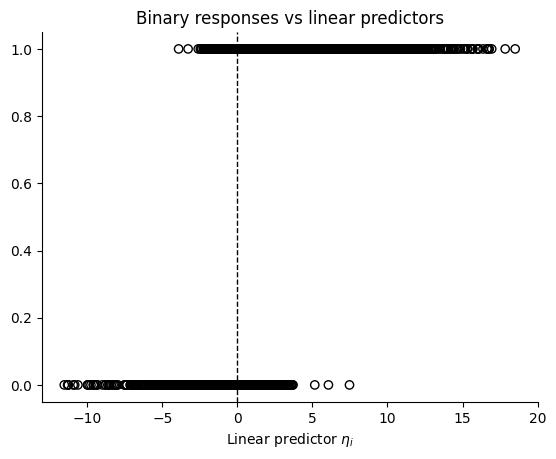

In [90]:
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  t = np.random.randint(0, 4000)
  plt.scatter(fit['eta'][:, t], fit['Y_tilde'][:, t], c='none', edgecolors='k')
sns.despine()
# linear_predictors = summary_table.loc["Inctercept", "mean"] + X * summary_table.loc[["SAT", "GPA", "Income"], "mean"].to_numpy()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')

## Interpretation

When controlling for GPA and income, we find that the coefficient for SAT scores is
$-0.272$. Hence, $e^{-0.272}=0.76$ implies that increases in SAT scores result in a 
$24\%$ reduction in odds that a student gets admitted to their top choice school.

At the same time GPA is associated with a $e^{0.094}=1.098$ or roughly $10\%$ increase in 
the odds of getting admitted to their top choice and income is associated with a $4\%$ increase in odds.

In [13]:
for i in range(fit['beta'].shape[0]):
    print(f"beta[{i}] : {np.exp(np.mean(fit['beta'][i, :]))}")

beta[0] : 0.7077570907391088
beta[1] : 1.180989342880443
beta[2] : 0.884388209481551


In [14]:
def plot_betas(fit):
    """Plot the distribution for betas and alpha"""
    n_bins = 100

    plot_range = fit["beta"].shape[0] + 1
    plt.figure(figsize=(8, 8))

    plt.suptitle("Distribution of Coefficients")
    ax1 = plt.subplot(plot_range, 1, 1)
    sns.histplot(fit['alpha'].flatten(), bins=n_bins);
    plt.vlines(0, 0, 150, colors='C1', ls="--")
    plt.ylabel("Intercept")

    for j in range(1, plot_range):
        plt.subplot(plot_range,1, j + 1, sharex=ax1)
        sns.histplot(fit['beta'][j-1,:], bins=n_bins)
        sns.despine()
        plt.ylabel(feature_cols[j-1])
        plt.vlines(0, 0, 150, colors='C1', ls="--")

    plt.tight_layout(pad=1)

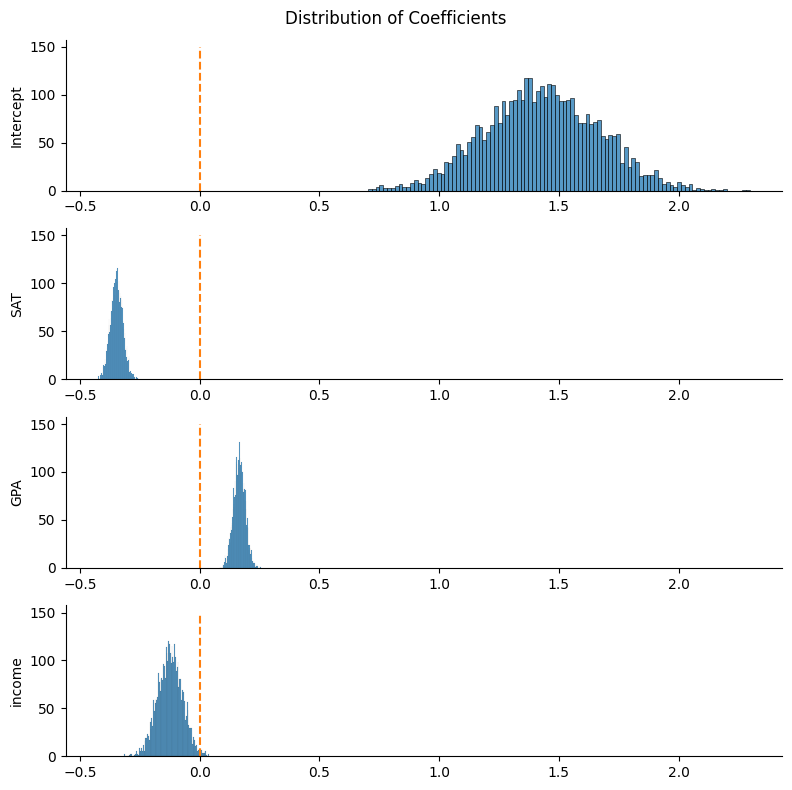

In [15]:
plot_betas(fit)

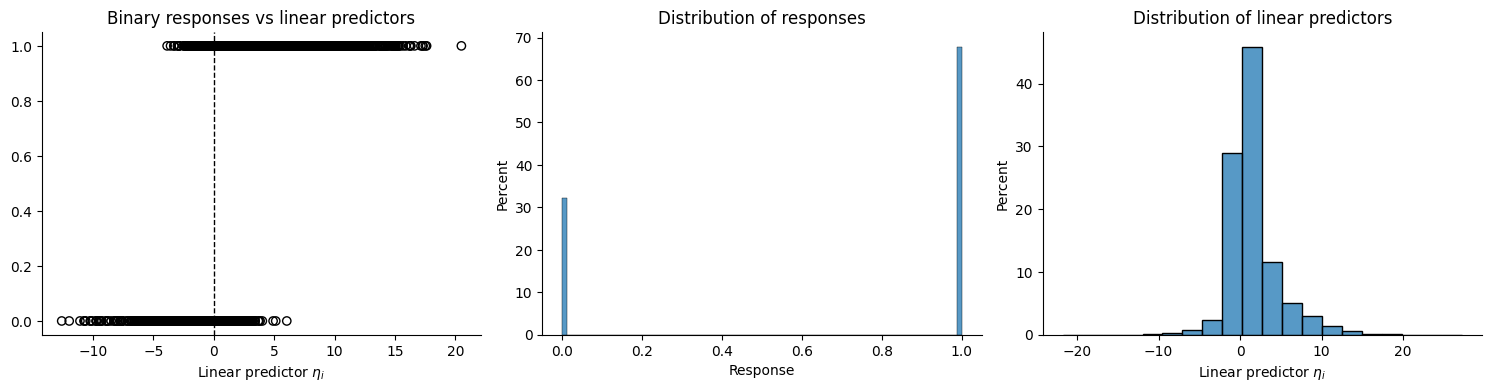

In [91]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  t = np.random.randint(0, 4000)
  plt.scatter(fit['eta'][:, t], fit['Y_tilde'][:, t], c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')


plt.subplot(132)
plt.title('Distribution of responses')
sns.histplot(fit['Y_tilde'].flatten(), stat='percent')
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'].flatten(), bins=20, stat='percent')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)

As we can see there doesn't seem to be a large distinction between linear predictors and the actual binary response.
This could be a result of observations that have the same features, but differ in other ways not captured in the data.
It's most likely a reflection that the model is not comprehensive enough to pick up on the distinctions between applicants.

ValueError: num must be 1 <= num <= 3, not 4

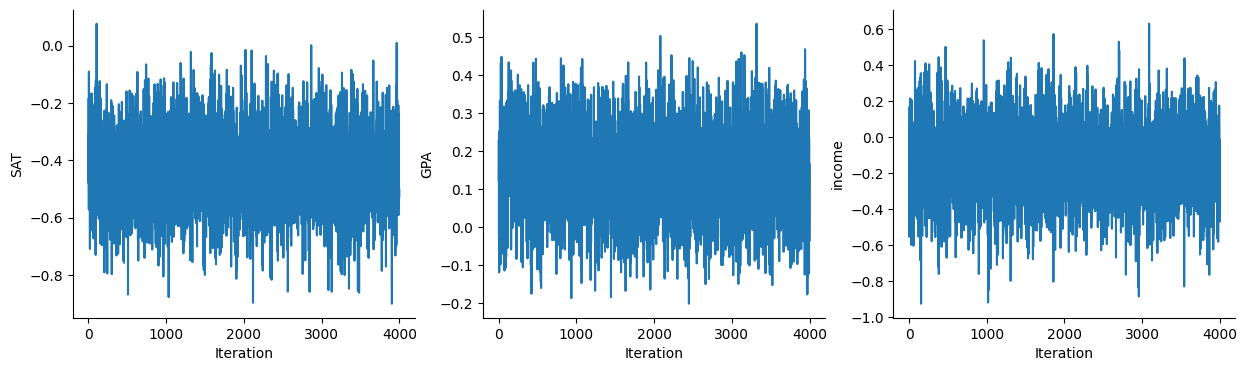

In [92]:
plt.figure(figsize=(15, 4))
plot_range = fit["beta"].shape[0]

for j in range(plot_range):
  plt.subplot(1, 3, j + 1)
  plt.plot(fit['beta'][j,:])
  sns.despine()
  plt.xlabel('Iteration')
  plt.ylabel(feature_cols[j])
  
plt.tight_layout(pad=1)

Use pareto smooted importance sampling leave-one-out cross-validation to estimate predictive performance

In [102]:
loo1, loos1, ks1 = psisloo(fit['log_lik'])
loo1_se = np.sqrt(np.var(loos1, ddof=1)*n)
print('elpd_loo: {:.4} (SE {:.3})'.format(loo1, loo1_se))

elpd_loo: -2.781e+03 (SE 0.576)


In [103]:
# check the number of large (> 0.5) Pareto k estimates
np.sum(ks1 > 0.5)


0

In [93]:
# Use arviz to compute the loo elpd
az.loo(az_fit, pointwise=True)

/home/mitch/.local/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 1000 log-likelihood matrix

         Estimate       SE
elpd_loo  -660.25    21.88
p_loo      197.62        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      790   79.0%
 (0.5, 0.7]   (ok)         96    9.6%
   (0.7, 1]   (bad)       102   10.2%
   (1, Inf)   (very bad)   12    1.2%

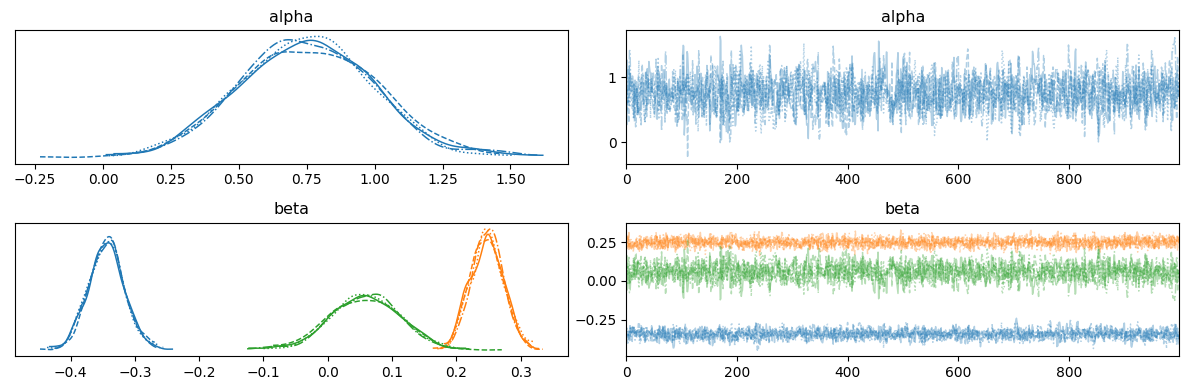

In [105]:
az.plot_trace(az_fit, var_names=["alpha", "beta"])
plt.tight_layout()
plt.show();

In [106]:
np.sum(az_fit["sample_stats"]["diverging"])

<xarray.DataArray 'diverging' ()>
array(0)

In [95]:
fit["y_new"].shape

(1000, 4000)

In [96]:
print(classification_report(y_test, fit["y_new"][:, 72]))

              precision    recall  f1-score   support

           0       0.35      0.41      0.38       294
           1       0.74      0.69      0.71       706

    accuracy                           0.61      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.62      0.61      0.61      1000



ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 414)

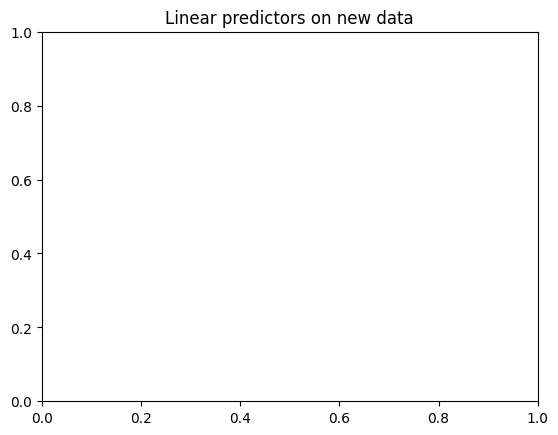

In [99]:
def inv_logit(x):
    """Return the inverse logit."""
    return np.exp(x) / (1 + np.exp(x))

plt.title("Linear predictors on new data")
new_linear_predictors = summary_table.loc["Intercept", "mean"] + X_test @ summary_table.loc[["SAT", "GPA", "Income"], "mean"].to_numpy().T
plt.scatter(new_linear_predictors, y_test, edgecolors='k', c="none")
plt.plot(sorted(new_linear_predictors), inv_logit(sorted(new_linear_predictors)));
plt.xlabel("Linear predictor $\eta_{i}$")
plt.ylabel("Binary response")
sns.despine()

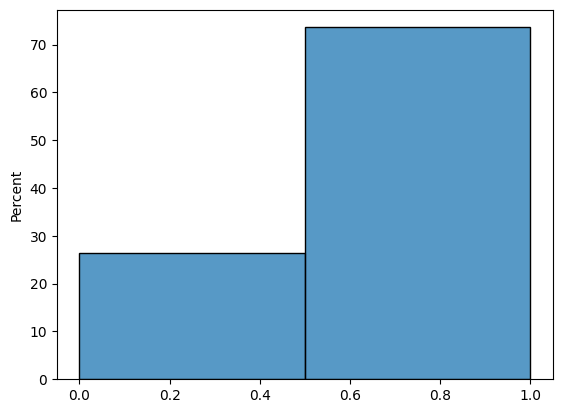

In [146]:
sns.histplot(fit["y_new"][:, 72], bins=2, stat="percent");

<AxesSubplot:ylabel='Percent'>

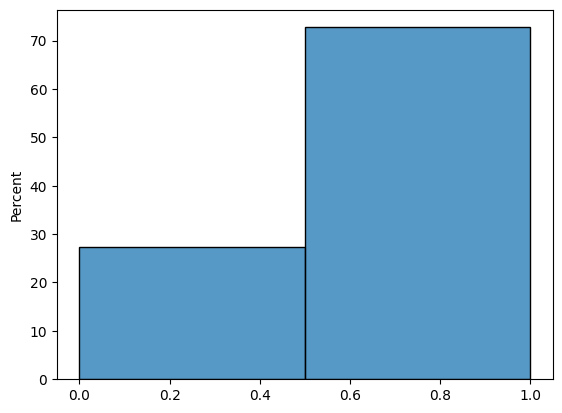

In [147]:
sns.histplot(y_test, bins=2, stat="percent")

In [151]:
sum(y_test)

7274

In [150]:
sum(fit["y_new"][:, 72])

7363.0